In [1]:
import os
import sys
sys.path.append('/Users/aghavamp/Desktop/Projects')
sys.path.append('/Users/aghavamp/Desktop/Projects/bimanual_wrist')
sys.path.append('/Users/aghavamp/Desktop/Projects/Functional_Fusion')
sys.path.append('/Users/aghavamp/Desktop/Projects/AnatSearchlight')
sys.path.append('/Users/aghavamp/Desktop/Projects/SUITPy')
import getpass
import importlib
import tqdm

import scipy.io as sio
import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from pathlib import Path
import seaborn as sns
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel
import glob
import matplotlib.patches as patches
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



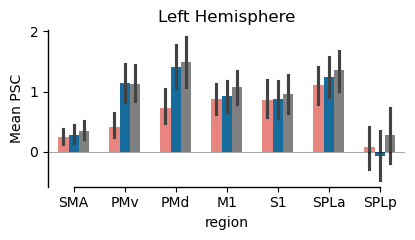

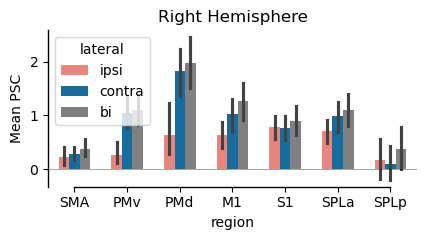

In [2]:
regions = ['SMA','PMv','PMd','M1','S1','SPLa','SPLp']
region_code = [5, 4, 3, 2, 1, 7, 8]
hem = ['L', 'R']
conditions = ['rhand','lhand','bi']
num_subj = 14

data = nb.load(os.path.join(analysisDir, 'psc.dscalar.nii'))
scalar_axis = data.header.get_axis(0)
row_names = [ax[0] for ax in scalar_axis]
idx_lhand = [i for i in range(len(row_names)) if 'lhand' in row_names[i]][0:num_subj]
idx_rhand = [i for i in range(len(row_names)) if 'rhand' in row_names[i]][0:num_subj]
idx_bi = [i for i in range(len(row_names)) if 'bi' in row_names[i]][0:num_subj]
indices = {'lhand': idx_lhand,
           'rhand': idx_rhand,
           'bi': idx_bi}
cons = data.get_fdata() 

ROI_L = nb.load('/Volumes/Diedrichsen_data$/data/Atlas_templates/fs_LR_32/ROI.32k.L.label.gii')
ROI_R = nb.load('/Volumes/Diedrichsen_data$/data/Atlas_templates/fs_LR_32/ROI.32k.R.label.gii')
ROI = {'L': ROI_L.darrays[0].data,
        'R': ROI_R.darrays[0].data}

ana = {'sn':[], 
       'region':[],
       'hem':[],
       'cond':[],
       'psc':[],
       'lateral':[]
}

for hidx, h in enumerate(hem):
    for r, roi in enumerate(regions):
        for cond in conditions:
            idx = indices[cond]
            for i in range(num_subj):
                con_sn = cons[idx[i], hidx*32492:(hidx+1)*32492] # left hem data
                region_con = con_sn[ROI[h]==r]

                ana['psc'].append(np.nanmean(region_con))
                ana['sn'].append(i)
                ana['region'].append(roi)
                ana['cond'].append(cond)
                ana['hem'].append(h)
                if cond=='lhand' and h=='L':
                    ana['lateral'].append('ipsi')
                elif cond=='lhand' and h=='R':
                    ana['lateral'].append('contra')
                elif cond=='rhand' and h=='L':
                    ana['lateral'].append('contra')
                elif cond=='rhand' and h=='R':
                    ana['lateral'].append('ipsi')  
                else:
                    ana['lateral'].append('bi')

df = pd.DataFrame(ana)

# boxplot:
fig, ax = plt.subplots(figsize=(4.5,2.5))
sns.barplot(data=df[df.hem=='L'], x='region', y='psc', hue='lateral', ax=ax, width=0.6, palette=['#F8766D','#0072B2','#808080'], hue_order=['ipsi','contra','bi'],legend=False)
ax.axhline(y=0, color='k', linestyle='-', alpha=0.5, linewidth=0.5)
# plt.ylim((-0.05,0.3))
plt.title(f'Left Hemisphere')
plt.ylabel('Mean PSC')
utils.please.make_it_pretty(ax=ax)
plt.tight_layout()
plt.savefig(f'../figures/PSC/average_PSC_leftHemisphere.pdf', bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(figsize=(4.5,2.5))
sns.barplot(data=df[df.hem=='R'], x='region', y='psc', hue='lateral', ax=ax, width=0.6, palette=['#F8766D','#0072B2','#808080'],  hue_order=['ipsi','contra','bi'])
ax.axhline(y=0, color='k', linestyle='-', alpha=0.5, linewidth=0.5)
# plt.ylim((-0.05,0.3))
plt.title(f'Right Hemisphere')
plt.ylabel('Mean PSC')
utils.please.make_it_pretty(ax=ax)
plt.tight_layout()
plt.savefig(f'../figures/PSC/average_PSC_rightHemisphere.pdf', bbox_inches="tight")
plt.show()


